# Projet Data

### Import libraries

In [1]:
import numpy as np
import random as rdm
import networkx as nx
import matplotlib.pyplot as plt
from pymongo import MongoClient
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from datetime import datetime, timedelta
import time
from sklearn.linear_model import LinearRegression
import statistics as st
from pulp import *
import statsmodels.api as sm
from scipy import stats
import statsmodels.stats.api as sms
import warnings
from time import time 
warnings.filterwarnings('ignore')

### DB connexion

In [2]:
# BDD connection
client = MongoClient('localhost',27017)
db=client['DataProject']
collection_trafic=db['vehicules_stamped']

### Dataframe creation

In [3]:
#Request the mongoDB
all_traffic=pd.DataFrame(collection_trafic.find())

#Drop the mongoID (useless here)
all_traffic=all_traffic.drop('_id', axis=1)

## I - Traffic analyse and descriptive statistics

### Function definition

*Get the traffic data for all edges or a single one*

In [4]:
def get_edge_stats(choice_edge, all):
    
    if all==False:
        print("---", "Etude de l'arête ", choice_edge, "---", "\n")
        result = collection_trafic.aggregate([
            {'$match': {'num_arete': choice_edge,}},
            {'$group': 
                {
                    '_id': {
                        'date': '$date',
                    },
                    'count': {'$sum': '$nb_vehicules'}
                }
            }
        ])
    elif all==True:
        print("---", "Etude de toutes les arrêtes","---", "\n")
        result = collection_trafic.aggregate([
          {
            "$group": {
              "_id": { "date" : "$date" },
              "count": { "$avg":"$nb_vehicules" }
            }
          }
        ])

    # result from mongoDB request
    result = list(result)

    # recover all date from an edge
    #dates = collection_trafic.distinct("date")
    #dates = list(dates)
    
    
    dates = None # convert string date to datetime
    if isinstance(result[0]['_id']['date'], str):
        dates = [(datetime.strptime(x['_id']['date'],"%d/%m/%Y %Hh%Mm"),x['count']) for x in result]
    else:
        dates = [((x['_id']['date']),x['count']) for x in result]
    
    # sort list by date
    sortedDates = sorted(
         dates,
         key=lambda x: x[0], reverse=False
    )
    
    return sortedDates

*Filter datas by time*

In [5]:
def get_specific_date_by_edge(sortedArray, choice_hour, choice_minute):

    target_time = []
    # recover specific data (all data corresponding to hour and minutes choice)
    for item in sortedArray:
        if (item[0].hour == choice_hour) and (item[0].minute == choice_minute):
            target_time.append(item)

    #print all tuple in target_time list
    print("---", "Données de circulation à",choice_hour, "h",choice_minute,"m", "---"
          ,"\n")
    for el in target_time:
        print(el)
    print("\n")
    
    return target_time

*Print statistics and boxplot*

In [6]:
def print_all(tab):

    tab_nb_vehicules = []
    # get nb_vehicules data only
    for date, nb_vehicules in tab:    
        tab_nb_vehicules.append(nb_vehicules)
    
    # sort list by date
    tab_nb_vehicules.sort()
    
    median = st.median(tab_nb_vehicules)
    moyenne = st.mean(tab_nb_vehicules)
    
    q1 = np.quantile(tab_nb_vehicules,0.25)
    q3 = np.quantile(tab_nb_vehicules,0.75)
    
    min_tab = min(tab_nb_vehicules)
    max_tab = max(tab_nb_vehicules)
    
    variance = st.variance(tab_nb_vehicules)
    ecart_type = st.pstdev(tab_nb_vehicules)
    
    print("---", "Données statistiques", "---")
    print('la médiane est de : ', median)
    print('la moyenne est de : ', round(moyenne, 2))
    print('le premier quartile est de : ', q1)
    print('le second quartile est de : ', q3)
    print('l\'intervalle interquartile est : [' , q1 , ';', q3 ,']')
    print('l\'étendue est : [' , min_tab , ';', max_tab ,']')
    print('la variance est de : ', variance)
    print('l\'écart type est de : ', ecart_type)
    
    
    # panda boxplot
    df = pd.DataFrame(tab_nb_vehicules, columns=['Boite']) 
    boxplot = df.boxplot(column=['Boite'])

*Analyze on edges*

--- Etude de l'arête  420 --- 

--- Données de circulation à 17 h 30 m --- 

(datetime.datetime(2020, 1, 1, 17, 30), 105)
(datetime.datetime(2020, 1, 2, 17, 30), 108)
(datetime.datetime(2020, 1, 3, 17, 30), 114)
(datetime.datetime(2020, 1, 4, 17, 30), 91)
(datetime.datetime(2020, 1, 5, 17, 30), 103)


--- Données statistiques ---
la médiane est de :  105
la moyenne est de :  104.2
le premier quartile est de :  103.0
le second quartile est de :  108.0
l'intervalle interquartile est : [ 103.0 ; 108.0 ]
l'étendue est : [ 91 ; 114 ]
la variance est de :  71.7
l'écart type est de :  7.573638491504595


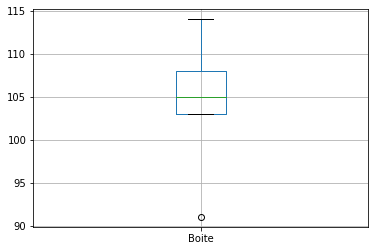

In [7]:
# specify the edge
edge = 420

# specify the time 
hour = 17
mins = 30

# choose between all edged or a particular one
all = False

# filter the data
full_array = get_edge_stats(edge, all)
timed_array = get_specific_date_by_edge(full_array, hour, mins)

# call fonction which return all statistic data 
print_all(timed_array)

## II - Linear regression

### Function definition

*Trace regression line*

In [8]:
def print_reg(traffic, result):
        
    hours = mdates.HourLocator(interval = 1)  
    minutes = mdates.MinuteLocator(interval = 15)  
    h_fmt = mdates.DateFormatter('%H:%M')
    t=sns.lineplot(x=pd.to_datetime(traffic['date']), y=result, color='r')
    t.set_xlim([pd.to_datetime(traffic['date']).min(),pd.to_datetime(traffic['date']).max()])
    t.xaxis.set_major_locator(hours)
    t.xaxis.set_major_locator(minutes)
    t.xaxis.set_major_formatter(h_fmt)
    
    return t

*Print traffic on differents hours and minutes*

In [9]:
def print_traffic(traffic_to_print):
    
    hours = mdates.HourLocator(interval = 1)  
    minutes = mdates.MinuteLocator(interval = 15)  
    h_fmt = mdates.DateFormatter('%H:%M')
    g = sns.scatterplot(x=pd.to_datetime(traffic_to_print['date']), y=traffic_to_print['nb_vehicules'])
    g.set_xlim([pd.to_datetime(traffic_to_print['date']).min(),pd.to_datetime(traffic_to_print['date']).max()])
    g.xaxis.set_major_locator(hours)
    g.xaxis.set_major_locator(minutes)
    g.xaxis.set_major_formatter(h_fmt)
    
    return g

*Get the traffic on a part of day for specific edge*

In [10]:
def traffic_edge(edge, matin, all_traffic):
    
    #get trafic data of a specific edge
    traffic = all_traffic.loc[all_traffic['num_arete']== edge]
    t = (traffic.loc[traffic['date'].dt.hour <= 9] if matin == True else traffic.loc[traffic['date'].dt.hour >= 17])
    
    #get only datas of the morning
    t.loc[0:,'date']=t['date'].dt.strftime('%H:%M')
    return t

*linear regression for an edge at a specific time*

In [11]:
def linear_regression(traffic_to_line,time, analyse):
    
    #convert the date to a int value
    traffic_to_line.loc[0:,'date']=pd.to_datetime(traffic_to_line['date'])
    
    # to improve
    traffic_to_line.loc[0:,'date']=[i.timestamp() for i in traffic_to_line['date']]
    
    # Define target
    y = traffic_to_line.nb_vehicules

    # Define features
    X=np.array(traffic_to_line['date']).reshape(-1, 1)

    # Define model
    model=LinearRegression()
    
    # fit the model
    model.fit(X,y)
    
    # convert the date as the target type
    _target = [i.timestamp() for i in pd.to_datetime(time)]
    
    #predicted results
    result=model.predict(np.array(_target).reshape(-1, 1))
    
    
    if analyse == True :
        regressor_OLS = sm.OLS(endog = y, exog = X).fit()

        print("Score du modèle:", model.score(X, y), "\n")

        print("Test d'homoghénéité")
        print('p valeur de Goldfeld–Quandt test est: ', sms.het_goldfeldquandt(y, regressor_OLS.model.exog)[1], "\n")

        print("Test de normalite (H0 : les donnes suivent une loi Normale)")
        print('p valeur de Jarque-Bera test est: ', stats.jarque_bera(regressor_OLS.resid)[1])
        print('p value de Shapiro-Wilk test est: ', stats.shapiro(regressor_OLS.resid)[1], "\n")


        print("Evaluation de la regression lineaire en utilisant la classe statsmodels :")
        print("La valeur du R2 est ", regressor_OLS.rsquared)
    
    return result

*Get predicted weight of an edge during a period (function used to get edge weight of a graphe)*

In [12]:
def predict_weight(num_arete, target, matin, all_traffic):
    
    # get a predict weight
    traffic=traffic_edge(num_arete, matin, all_traffic)
    result = linear_regression(traffic, target, False)
    
    return result

### Display regression

*You have to specify edge number to show regression*

Score du modèle: 0.5496468575050215 

Test d'homoghénéité
p valeur de Goldfeld–Quandt test est:  0.3724299750663221 

Test de normalite (H0 : les donnes suivent une loi Normale)
p valeur de Jarque-Bera test est:  0.00843342586229412
p value de Shapiro-Wilk test est:  0.00296246400102973 

Evaluation de la regression lineaire en utilisant la classe statsmodels :
La valeur du R2 est  4.928152147587461e-06


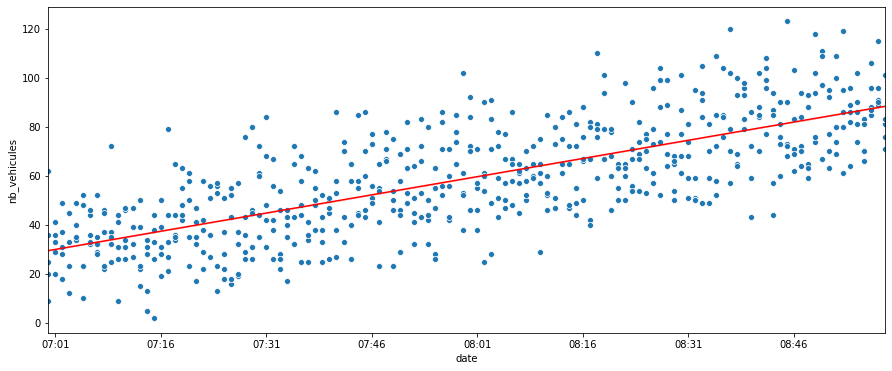

Score du modèle: 0.5106954628517972 

Test d'homoghénéité
p valeur de Goldfeld–Quandt test est:  0.8219159938578677 

Test de normalite (H0 : les donnes suivent une loi Normale)
p valeur de Jarque-Bera test est:  0.19065972687193977
p value de Shapiro-Wilk test est:  0.19994452595710754 

Evaluation de la regression lineaire en utilisant la classe statsmodels :
La valeur du R2 est  -9.323038234310133e-06


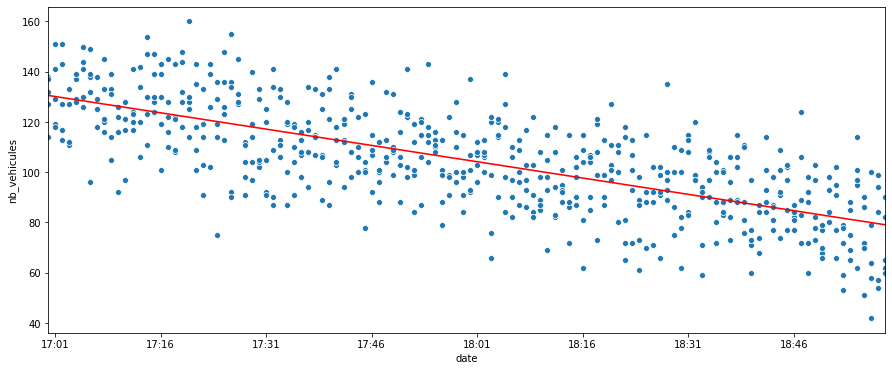

In [13]:
def show_reg(num_arete, all_traffic):
    traffic_m=traffic_edge(num_arete, True, all_traffic)
    result_m = linear_regression(traffic_m.copy(), traffic_m['date'], True)
    plt.figure(figsize=(15,6))
    
        
    gm=print_traffic(traffic_m)
    rm= print_reg(traffic_m, result_m)
    
    plt.show()


    traffic_e=traffic_edge(num_arete, False, all_traffic)
    result_e = linear_regression(traffic_e.copy(), traffic_e['date'], True)
    plt.figure(figsize=(15,6))
    
        
    ge=print_traffic(traffic_e)
    re= print_reg(traffic_e, result_e)
    
    plt.show()

# Call function to get informations
show_reg(1, all_traffic)

## III - Create Complete Graph

### Initialization

In [14]:
# Vertices Number
total_sommets=10

hourParameter = "08:00"
matin = True
# Vertices List
som_l = [i for i in range(total_sommets)]

### Function definition

*Print complete graph*

In [15]:
def show_graph(G): 
    weights = [e for e in nx.get_edge_attributes(G,'weight').values()]
    pos=nx.spring_layout(G)
    colors=weights
    cmap=plt.cm.Blues
    vmin = min(colors)
    vmax = max(colors)
    nx.draw(G, pos, node_color='mediumpurple', edge_color=colors, width=4, edge_cmap=cmap, with_labels=True)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    plt.colorbar(sm)
    plt.show()

*Recover estimate edge's weight for a time (Using linear regression)*


In [16]:
def get_weight_predict(nb_arete, time_string):
    # Recuperation des aretes
    
    # on test si nb arete > 500

    num_arete_l=([i for i in range(nb_arete)] if nb_arete <= 500 else [i for i in range(500)])
    tab_weight=[]
    tab_edges=[]
    # Pour chaque arete on recupere les estimations
    for num_arete in num_arete_l:

        predict= predict_weight(num_arete, [time_string], matin, all_traffic)

        #print("Num arete : {} Poid estimé : {} pour {}".format(num_arete, predict[0], time_string))

        # on cree nos tableaux qui serviront a créer un graphe de prevision
        tab_weight.append(predict[0])
        #tab_edges.append(num_arete)
        
    # on complete avec du random
    while True:
        if len(tab_weight) < nb_arete:
            tab_weight.append(rdm.randint(0,200))

        else:break
    

    return tab_weight

### Create complete graph and add predict weight to edges

We start by creating an adjacency matrix that corresponds to a so-called "complete" graph.

In [17]:
adjacency = []
for x in range(total_sommets+1):
    adjacency.append([])
    for y in range(total_sommets+1):
        if y == x :
            adjacency[x].append(0)
        else:
            adjacency[x].append(1)
adjacency = np.array(adjacency)

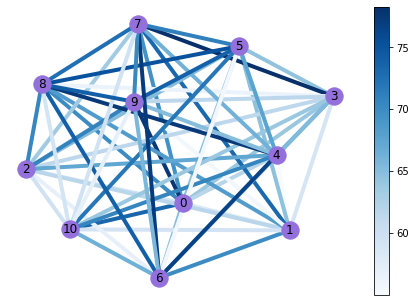

In [18]:
rows, cols = np.where(adjacency == 1)
edges = zip(rows.tolist(), cols.tolist())
G = nx.Graph() # This is a Directed graph
G.add_edges_from(edges)

only_Traffic=get_weight_predict(len(G.edges()), hourParameter)
G.add_weighted_edges_from(np.column_stack((np.array(G.edges()), np.array(only_Traffic))))

# Save the position of nodes
pos = nx.spring_layout(G) # positions for all nodes
show_graph(G) 

## IV - Algorithms

##  Genetic algo implementation

### Function definition

*Get the total weight for a way*

In [19]:
def calc_weight(start, all_ways, graph, nb_livreurs):
    
    # On definit la liste qui contiendra nos poids
    som_weight_l=[]
    
    # Pour chaque chemin
    for long_way in all_ways:
        sum_weight=0
        
        # On divise le chemin en nombre de livreur
        split_way=np.array_split(long_way, nb_livreurs)
        
        for way in split_way:
            
            # On part de la base
            sum_weight+=graph.get_edge_data(start,way[0])["weight"]

            # Pour chaque element de la solution on calcul leur chemin              
            for e in range(len(way)-1):

                sum_weight+=graph.get_edge_data(way[e],way[e+1])["weight"]

            # On revient a la base
            sum_weight+=graph.get_edge_data(way[-1],start)["weight"]           

        # On ajoute le poid a notre liste
        som_weight_l.append(sum_weight)
    
    return som_weight_l

*Get index from best ways in weight function*

In [20]:
def get_best(way_weight_l):
    
    # On definit une liste qui contiendra nos index
    index_l=[]
    
    # On fait une copie de notre liste
    copy_way_weight_l=list(way_weight_l)

    # x Best Chromosomes
    for i in range(8):
        index_best=way_weight_l.index(min(copy_way_weight_l))
        index_l.append(index_best)
        copy_way_weight_l.pop(copy_way_weight_l.index(min(copy_way_weight_l)))

        
    return index_l

*Function to mutate way*

In [21]:
def mutation(way):
    # On fait un décalage dans notre liste
    way.insert(0,way.pop())
    return way

*Function to fusion best ways*

In [22]:
def cross(new_way, way_2):
    
    # On selectionne les sommets sur lesquels on est pas encore passé
    end = [i for i in way_2 if i not in new_way]
    
    # Merging
    new_way.extend(end)
    
    return new_way

*Function to transform way*

In [23]:
def transform_best(all_ways,index, population):
    
    # On recupère une partie des meilleurs chemins
    best_1=all_ways[index[0]][0:int(len(all_ways[index[0]])*rdm.random())]
    best_2=all_ways[index[1]]
    
    
    best_3=all_ways[index[2]][0:int(len(all_ways[index[0]])*rdm.random())]
    best_4=all_ways[index[3]]
        
    # On récupère les autres solutions correctes
    last_best=[all_ways[index[i+4]] for i in range(4)]

    # On redéfinit nos solutions
    all_ways=[]
    
    # On fusionne les 4 meilleures solutions
    all_ways.append(cross(best_1, best_2))
    all_ways.append(cross(best_3, best_4))
    
    # On fait une mutation de nos autres solutions
    for way in last_best:
        all_ways.append(mutation(way))

    # On recréé une nouvelle population en ajoutant la solution
    all_ways=add_pop(population, all_ways)
    
    return all_ways

*Function to add new ramdom ways*

In [24]:
def add_pop(population, all_ways):

    for p in range(population-len(all_ways)):

        # On genere des solution aleatoires
        rdm.shuffle(all_ways[0])

        # On ajoute une solution a notre liste
        all_ways.append(list(all_ways[0]))

    return all_ways

### Initialization Genetic Solution

In [25]:
#-- On definit la liste des points a livrer
client_l= [i for i in range(1,total_sommets+1)]


#-- On definit le point de base
base=0

#-- Number of phenotypes
population=10

#-- Generations generate
iterations=200

nb_livreurs = 5

### Genectic Algo

In [26]:
def genetic_algo():

    # On defini une liste solution
    all_ways=[]
    all_ways=add_pop(population,[client_l])
    global_best_weight=0
    global_best_way=[]
    converg=[]

    # On genere une nouvelle population
    for i in range(iterations):


        # On calcul le poid de nos solutions
        sol_poid=calc_weight(base, all_ways, G, nb_livreurs)

        # On recupere les index des 8 meilleurs chemins
        local_best_index=get_best(sol_poid)


        # On met a jour le meilleur chemin
        if sol_poid[local_best_index[0]]<global_best_weight or global_best_weight==0:
            global_best_weight=sol_poid[local_best_index[0]]
            global_best_way=all_ways[local_best_index[0]]


            # On redivise le chemin en fonction du nombre de livreur
            split_way=np.array_split(global_best_way, nb_livreurs)

            print("Iteration : {}".format(i))
            num_livreur=0
            for x in split_way:
                num_livreur+=1
                print("Pour le livreur {} : ".format(num_livreur))
                print(base, "-> ", end = '')
                for ele in x: 
                    print(ele, "-> ", end = '') 
                print(base)
            print("Poid total : {} \n".format(global_best_weight))
        converg.append(global_best_weight)


        # On tranforme nos chemins pour en générer de nouveaux
        all_ways=transform_best(all_ways,local_best_index, population)
        plt.plot(range(len(converg)), converg)
    
    return split_way,global_best_weight

### Show best way

In [27]:
def displayResults(routes):
    nx.draw_networkx_nodes(G, pos,width=4,with_labels=True)
    nx.draw_networkx_nodes(G,pos,nodelist=[0],node_color='r') # Set Base Point color in red    
    
    colors = ['b','r','y','orange','g']
    for r in routes:
        color = colors.pop(np.random.randint(0, len(colors)))
        nx.draw_networkx_edges(G, pos, edgelist=r, edge_color=color)
            
    plt.axis('off')
    plt.show()

### Run genetic algo, get best way then print it

*Get the best way*

Iteration : 0
Pour le livreur 1 : 
0 -> 5 -> 3 -> 0
Pour le livreur 2 : 
0 -> 10 -> 8 -> 0
Pour le livreur 3 : 
0 -> 1 -> 9 -> 0
Pour le livreur 4 : 
0 -> 7 -> 4 -> 0
Pour le livreur 5 : 
0 -> 2 -> 6 -> 0
Poid total : 966.7967641316354 

Iteration : 29
Pour le livreur 1 : 
0 -> 8 -> 3 -> 0
Pour le livreur 2 : 
0 -> 1 -> 9 -> 0
Pour le livreur 3 : 
0 -> 10 -> 2 -> 0
Pour le livreur 4 : 
0 -> 4 -> 7 -> 0
Pour le livreur 5 : 
0 -> 6 -> 5 -> 0
Poid total : 957.9882100634277 



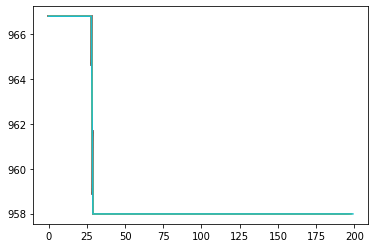

In [28]:
initial_t = time()

result = genetic_algo()

final_t = time()
gnTime = final_t - initial_t

routesGenetic = []
for best_route in result[0]:
    route = []
    for idx,point in enumerate(best_route):
        if idx > 0 or idx+1 == len(best_route):
            route.append((fromC,point))
        else:
            route.append((0,point)) # start from base
        fromC = point
    route.append((best_route[-1],0)) # get back to base
    routesGenetic.append(route)


*Display the way*

## Pulp Default Solver Implementation

In [29]:
rows, cols = np.where(adjacency == 1)
edges = zip(rows.tolist(), cols.tolist())
newGraph = nx.DiGraph()
newGraph.add_edges_from(edges)

only_Traffic=get_weight_predict(len(newGraph.edges()), hourParameter)
newGraph.add_weighted_edges_from(np.column_stack((np.array(newGraph.edges()), np.array(only_Traffic))))

In [30]:
# set of clients
N = client_l
# all nodes (0 = including depot)
V = [0] + N
# adjacency list including traffic
c = {(a,b):c['weight'] for a,b,c in newGraph.edges.data()}

K = nb_livreurs # same as genetic parameter by default (updatable)

In [31]:
prob = LpProblem("VRP", LpMinimize)

In [32]:
x = LpVariable.dicts('x',c, 0,1,LpBinary)

In [33]:
u = LpVariable.dicts('u', V, 0, len(N), LpInteger)

**Objective Function**

In [34]:
prob += lpSum([x[(i,j)]* c[(i,j)] for (i,j) in c])

In [35]:
depot = 0
#print(f"Depot : {depot}")

#constraints
for k in V:
    cap = 1 if k != depot else K
    #inbound connection
    prob+= lpSum([ x[(i,k)] for i in V if (i,k) in x]) == cap
    #outbound connection
    prob+= lpSum([ x[(k,i)] for i in V if (k,i) in x]) == cap
    

#subtour elimination
O=len(V)/K
for i in V:
    for j in V:
        if i != j and (i != depot and j!= depot) and (i,j) in x:
            prob += u[i] - u[j] <= (O)*(1-x[(i,j)]) - 1

In [36]:
initial_t = time()

%time prob.solve()

final_t = time()
lpTime = final_t - initial_t

Wall time: 1.27 s


In [37]:
print(LpStatus[prob.status])
print("Minimal value found :", value(prob.objective))
non_zero_edges = [ e for e in x if value(x[e]) != 0 ]

Optimal
Minimal value found : 929.9606072288007


In [38]:
beginnig_routes = [[e] for e in non_zero_edges if e[0] == depot]

In [39]:
routesLP = beginnig_routes
i = 0
for edge in beginnig_routes:
    target = edge[0][-1]
    while target != depot:
        next_site = [e for e in non_zero_edges if e[0] == target][-1]
        routesLP[i].append(next_site)
        target = next_site[-1]
        
    i+=1

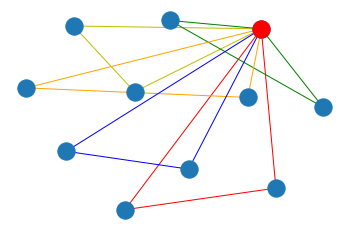

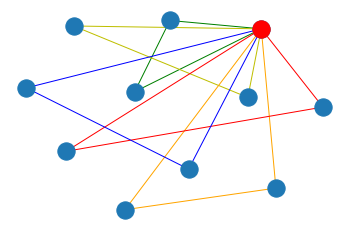

In [40]:
displayResults(routesLP)
displayResults(routesGenetic)

## Comparison

In [41]:
minGenetic = result[1]
minLP =  value(prob.objective)


print(f"Result returned by Genetic Algorithm : {minGenetic} in {gnTime} secs.")
print(f"Result returned by Linear Programming : {minLP} in {lpTime} secs.")

Result returned by Genetic Algorithm : 957.9882100634277 in 0.7343442440032959 secs.
Result returned by Linear Programming : 929.9606072288007 in 1.272019624710083 secs.
